In [ ]:
# This is a series of examples using the icanswim/qchem quantum mechanic machine learning repo
# icanswim/qchem utilizes the icanswim/cosmosis data science machine learning repo

In [1]:
import sys # required for relative imports in jupyter lab
sys.path.insert(0, '../')

import warnings
warnings.filterwarnings('ignore', category=UserWarning,
                            message='TypedStorage is deprecated')

from cosmosis.model import FFNet
from cosmosis.dataset import SKDS
from cosmosis.learning import Learn, Selector

from dataset import QM7, QM7b, QM7X, ANI1x, QM9, PGDS
from model import pyg_model, GraphNet

from torch.optim import Adam
from torch.nn import MSELoss, L1Loss, NLLLoss, CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch_geometric.loader import DataLoader



In [2]:
#example exploring cosmosis/qchem QM9 dataset 
#use the qchem rdkit branch for rdkit data augmentation

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['atomic_number','mulliken'],
                                                             'coulomb': ['coulomb'],
                                                            },
                                             'criterion_input': {'target': ['U0']}},
                              'n': 1000, #non-random subset for testing
                              'n_conformers': 1,
                              'pad': False,
                              'pad_feats': ['mulliken','coulomb','atomic_number'],
                              'as_tensor': False,
                              'use_pickle': False,
                              'flatten': False}}

qm9 = QM9(**ds_params['train_params'])
qm9[1]

creating QM9 dataset...
molecules scanned:  1
molecules created:  1
total molecules scanned:  1000
total uncharacterized molecules removed:  25
total molecules created:  975
CDataset created...


{'model_input': {'X': array([ 6.      ,  1.      ,  1.      ,  1.      ,  1.      , -0.535689,
          0.133921,  0.133922,  0.133923,  0.133923], dtype=float32),
  'coulomb': array([[36.858112 , 10.765888 , 10.765863 , 10.765641 , 10.765677 ],
         [ 0.9157932,  0.5      ,  1.7943105,  1.7942736,  1.7942796],
         [ 0.9157932,  1.7943147,  0.5      ,  1.7942736,  1.7942796],
         [ 0.9157932,  1.7943147,  1.7943105,  0.5      ,  1.7942796],
         [ 0.9157932,  1.7943147,  1.7943105,  1.7942736,  0.5      ]],
        dtype=float32)},
 'criterion_input': {'target': array([-40.47893], dtype=float32)}}

In [3]:
#example exploring cosmosis/qchem QM9 dataset
l, s, li, si = 0, 9999, 0, 0
for i in qm9.ds_idx:
    d = qm9[i]['model_input']['X'].shape[0]
    if d > l:
        l = d
        li = i
    if d < s:
        s = d
        si = i
print('longest molecule index: ', li, ' length: ', l)
print('shortest molecule index: ', si, ' length: ', s)
qm9[si]

longest molecule index:  228  length:  40
shortest molecule index:  3  length:  6


{'model_input': {'X': array([ 8.      ,  1.      ,  1.      , -0.589706,  0.294853,  0.294853],
        dtype=float32),
  'coulomb': array([[73.51671  , 35.90347  , 35.90347  ],
         [ 1.0393857,  0.5      ,  4.4879336],
         [ 1.0393857,  4.4879336,  0.5      ]], dtype=float32)},
 'criterion_input': {'target': array([-76.4047], dtype=float32)}}

In [4]:
#example exploring cosmosis/qchem PyG dataset wrapper with Data object output
import numpy as np
ds_params = {'train_params': {'dataset': 'QM9',
                              'pg_params': {'root': './data/'}}}

pgds = PGDS(**ds_params['train_params'])
ds_idx = np.arange(1000)
selector = Selector(train_idx=ds_idx)
selector('train')
loader = DataLoader(pgds, batch_size=2, sampler=selector)
batch = next(iter(loader))
print(batch)
print(batch.ptr)
print(batch.idx)
print(batch.x)
print(pgds[1])
print(pgds[1].x)
print(pgds[1].idx)

creating pytorch geometric QM9 dataset...
CDataset created...
DataBatch(x=[28, 11], edge_index=[2, 56], edge_attr=[56, 4], y=[2, 19], pos=[28, 3], z=[28], name=[2], idx=[2], batch=[28], ptr=[3])
tensor([ 0, 14, 28])
tensor([654, 863])
tensor([[0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 2.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 2.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 2.],
        [0., 0., 0., 1., 0., 8., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [

In [5]:
#example exploring cosmosis/qchem PyG dataset wrapper, padded with dictionary output
ds_params = {'train_params': {'dataset': 'QM9',
                              'use_pyg': False,
                              'pad': (29,11),
                              'pad_feats': ['x'],
                              'flatten': False,
                              'input_dict': {'model_input': {'X': ['x']},
                                             'criterion_input': {'target': ['y']}},
                              'pg_params': {'root': './data/'}}}

pgds = PGDS(**ds_params['train_params'])
pgds[1]

creating pytorch geometric QM9 dataset...
CDataset created...


{'model_input': {'X': tensor([[0., 0., 1., 0., 0., 7., 0., 0., 0., 0., 3.],
          [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
          [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
          [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0

creating QM9 dataset...
molecules scanned:  1
molecules created:  0
molecules scanned:  10001
molecules created:  9551
total molecules scanned:  10450
total uncharacterized molecules removed:  265
total molecules created:  9735
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:03.085886
epoch: 0, lr: 0.01
train loss: 273.29943302699496, val loss: 39.083595275878906
learning time: 0:00:14.207030
epoch: 8, lr: 0.01
train loss: 14.420730795179095, val loss: 16.8307433658176
test loss: 10.347109264797634
learning time: 0:00:15.956084


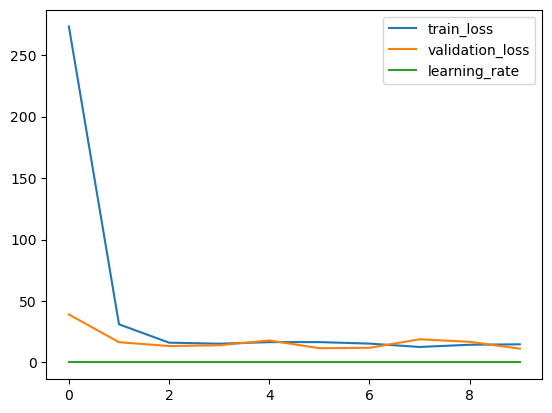

In [6]:
#example cosmosis/qchem QM9 dataset with filter
#use the qchem rdkit branch for rdkit data augmentation

qm9_features = ['A','B','C','mu','alpha','homo','lumo', 'gap','r2','zpve',
                'U0','U','H','G','Cv','qm9_n_atoms','qm9_block','qm9_atom_type',
                'qm9_xyz','mulliken','in_file','smile','distance','coulomb']

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['U0']}},
                              'n': 10000, #non-random subset for testing
                              'n_conformers': 1,
                              'pad': 29,
                              'pad_feats': ['mulliken','coulomb','atomic_number'],
                              'as_tensor': True,
                              'filter_on': ('n_atoms','>','10'), #filter out molecules with less than 10 atoms
                              'use_pickle': False,
                              'flatten': True}}


model_params = {'in_channels': 29*29, 
                'hidden': 4096, 
                'out_channels': 1, 
                'model_name': 'funnel'
               }
                
metrics_params = {'report_interval': 1,
                  'log_plot': False}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15),
                 'subset': .2 #create random subset
                }

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM9], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          batch_size=32, epochs=10)

creating pytorch geometric TUDataset dataset...
CDataset created...
GNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:00.801727
epoch: 0, lr: 0.01
train loss: 0.08281516609713435, val loss: 0.07565302401781082
sklearn train metric: 0.6171875, sklearn validation metric: 0.75
learning time: 0:00:06.476158
epoch: 7, lr: 0.01
train loss: 0.06708970945328474, val loss: 0.07724719991286595
sklearn train metric: 0.71875, sklearn validation metric: 0.7083333333333334
test loss: 0.0718474102516969
learning time: 0:00:08.426010
sklearn test metric: 
0.625 



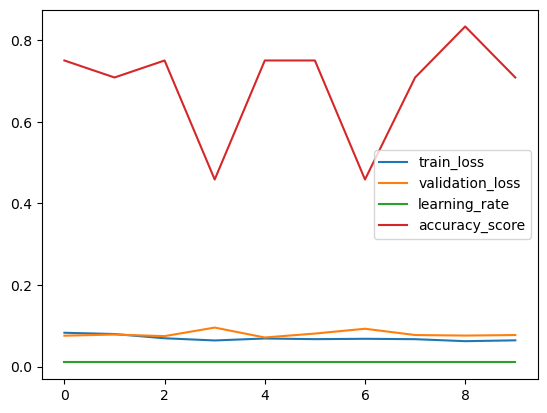

In [7]:
#example cosmosis/qchem PyG dataset wrapper with Data object output and
#sklearn metrics and custom PyG model

model_params = {'in_channels': 7,
                'hidden': 64,
                'out_channels': 2}

ds_params = {'train_params': {'dataset': 'TUDataset',
                              'use_pyg': True,
                              'pg_params': {'root': './data/',
                                            'name': 'MUTAG'}}}

metrics_params = {'report_interval': 5,
                  'log_plot': False,
                  'sk_metric_name': 'accuracy_score',
                  'sk_params': {}}

opt_params = {'lr': 0.01}

crit_params = {}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 5}

l = Learn([PGDS], GraphNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=CrossEntropyLoss, DataLoader=DataLoader,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=8, epochs=10)

creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:06.839522
epoch: 0, lr: 0.01
train loss: 484.47987272759445, val loss: 19.20487762752332
learning time: 0:00:20.589283
epoch: 2, lr: 0.01
train loss: 12.357621211631626, val loss: 11.894186973571777
learning time: 0:00:34.509883
epoch: 4, lr: 0.01
train loss: 11.445997729688798, val loss: 11.345502652620015
learning time: 0:00:48.356423
epoch: 6, lr: 0.01
train loss: 11.19541280543437, val loss: 11.822076082229614
learning time: 0:01:01.716556
epoch: 8, lr: 0.01
train loss: 10.988644864378857, val loss: 11.084053491291247
test loss: 10.863544100209287
learning time: 0:01:10.251903


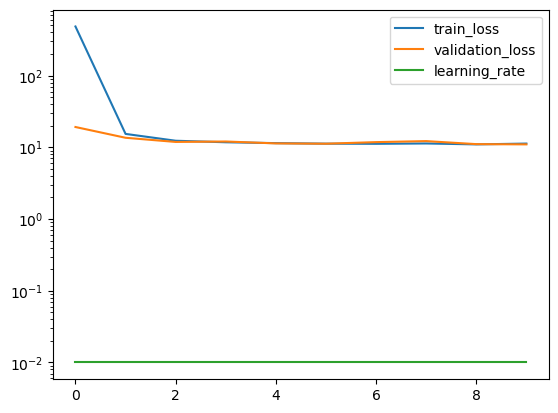

In [8]:
#example cosmosis/qchem PyG dataset wrapper with custum transform with
#dictionary output and custom model
import numpy as np

class IndexTransform():
    #select index i from dataset with multiple target outputs
    def __init__(self, i):
        self.i = i
    def __call__(self, arr):
        return np.reshape(arr[self.i], (1,))

model_params = {'in_channels': 319, 
                'hidden': 512, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'dataset': 'QM9',
                              'use_pyg': False,
                              'pad': (29,11),
                              'pad_feats': ['x'],
                              'flatten': True,
                              'target_transform': [IndexTransform(1)],
                              'input_dict': {'model_input': {'X': ['x']},
                                             'criterion_input': {'target': ['y']}},
                              'pg_params': {'root': './data/'}}}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1}

l = Learn([PGDS], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=256, epochs=10)

CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:01.028971
epoch: 0, lr: 0.01
train loss: 1531.2799008018092, val loss: 1501.6933898925781
learning time: 0:00:10.156778
epoch: 10, lr: 0.01
train loss: 37.0465531600149, val loss: 34.38897657394409
test loss: 33.12283992767334
learning time: 0:00:18.735089


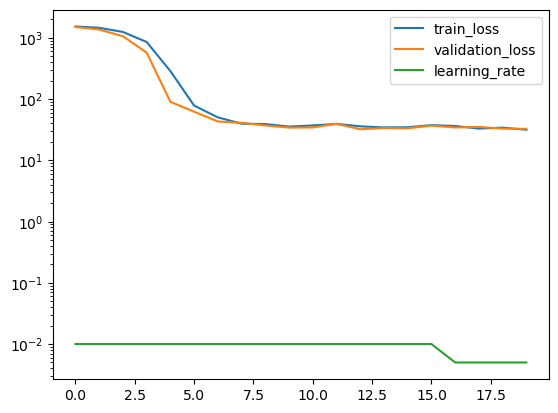

In [9]:
#example using cosmosis/qchem QM7 dataset and custom model
model_params = {'in_channels': 23*23, 
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['ae']}},
                              'in_file': './data/qm7/qm7.mat',
                              'flatten': True}}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 3,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM7], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=256, epochs=20)

CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:00.996614
epoch: 0, lr: 0.01
train loss: 1558.8743767989308, val loss: 1532.6652526855469
learning time: 0:00:10.187009
epoch: 10, lr: 0.01
train loss: 50.28148992438065, val loss: 57.856059074401855
test loss: 49.93651580810547
learning time: 0:00:18.817037


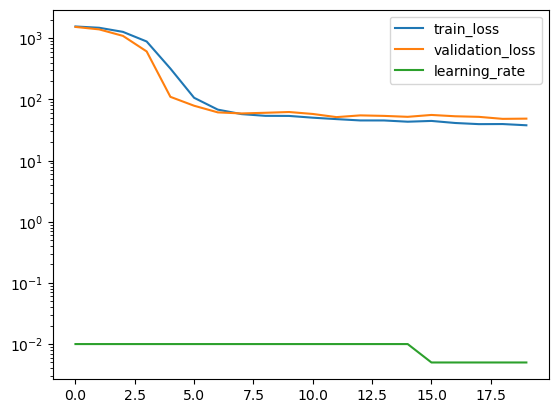

In [10]:
#example using the cosmosis/qchem QM7b dataset and custom model
model_params = {'in_channels': 23*23, 
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['E']}},
                              'in_file': './data/qm7b/qm7b.mat',
                              'flatten': True}}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 3,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM7b], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params, 
          batch_size=256, epochs=20)

In [11]:
#example exploring cosmosis/qchem QM7X dataset

features = ['DIP','HLgap','atC6','atNUM','atPOL','atXYZ','eAT','hDIP',
            'eC','eDFTB+MBD','eEE','eH','eKIN','eKSE','eL','eMBD','eNE', 
            'eNN','ePBE0','ePBE0+MBD','eTS','eX','eXC','eXX','hCHG', 
            'hRAT','hVDIP','hVOL','mC6','mPOL','mTPOL','pbe0FOR', 
            'sMIT','sRMSD','totFOR','vDIP','vEQ','vIQ','vTQ','vdwFOR','vdwR',
            'coulomb'] #(1110,) with pad=23

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['atNUM']},
                                             'criterion_input': {'target': ['eAT']}},
                              'pad': None, #longest molecule = 23
                              'as_tensor': False,
                              'n': 1000, #non-random subset for testing
                              'selector': ['opt'],
                              'flatten': True}}

qm7x = QM7X(**ds_params['train_params'])

l, m = 0, 0
for i in qm7x.ds_idx:
    s = qm7x[i]['model_input']['X'].shape[0]
    if s > l:
        l = s
        m = i
print('longest molecule length: ', l, ' index: ', m)
print(qm7x[m]['model_input']['X'].shape) 
qm7x[m]


mapping...  <HDF5 file "1000.hdf5" (mode r)>
mapping...  <HDF5 file "2000.hdf5" (mode r)>
mapping...  <HDF5 file "3000.hdf5" (mode r)>
mapping...  <HDF5 file "4000.hdf5" (mode r)>
mapping...  <HDF5 file "5000.hdf5" (mode r)>
mapping...  <HDF5 file "6000.hdf5" (mode r)>
mapping...  <HDF5 file "7000.hdf5" (mode r)>
mapping...  <HDF5 file "8000.hdf5" (mode r)>
molecular formula (idmol) mapped:  1000
total molecular structures (idconf) mapped:  3723
CDataset created...
longest molecule length:  20  index:  233
(20,)


{'model_input': {'X': array([6., 6., 6., 6., 6., 6., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1.], dtype=float32)},
 'criterion_input': {'target': array([89.31956], dtype=float32)}}

mapping...  <HDF5 file "1000.hdf5" (mode r)>
mapping...  <HDF5 file "2000.hdf5" (mode r)>
mapping...  <HDF5 file "3000.hdf5" (mode r)>
mapping...  <HDF5 file "4000.hdf5" (mode r)>
mapping...  <HDF5 file "5000.hdf5" (mode r)>
mapping...  <HDF5 file "6000.hdf5" (mode r)>
mapping...  <HDF5 file "7000.hdf5" (mode r)>
mapping...  <HDF5 file "8000.hdf5" (mode r)>
molecular formula (idmol) mapped:  1000
total molecular structures (idconf) mapped:  3723
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:00.954025
epoch: 0, lr: 0.01
train loss: 64.38961715698242, val loss: 61.19342041015625
test loss: 3.258817195892334
learning time: 0:00:09.281258


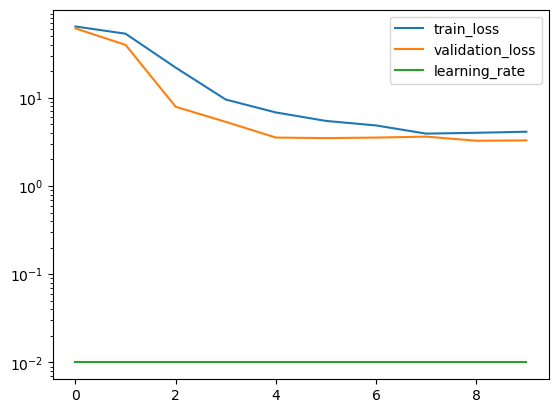

In [12]:
#example using the cosmosis/qchem QM7X dataset with filter and custom model
model_params = {'in_channels': 23*23,
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel'}

features = ['DIP','HLgap','atC6','atNUM','atPOL','atXYZ','hDIP','eAT',
            'eC','eDFTB+MBD','eEE','eH','eKIN','eKSE','eL','eMBD','eNE', 
            'eNN','ePBE0','ePBE0+MBD','eTS','eX','eXC','eXX','hCHG', 
            'hRAT','hVDIP','hVOL','mC6','mPOL','mTPOL','pbe0FOR', 
            'sMIT','sRMSD','totFOR','vDIP','vEQ','vIQ','vTQ','vdwFOR','vdwR',
            'coulomb','distance']

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['eAT']}},
                              'pad': 23,
                              'selector': ['opt'],
                              'flatten': True,
                              'n': 1000, #non-random subset for testing
                             }}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15),
                 #'subset': .2 #create random subset
                } 

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM7X], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=64, epochs=10)

molecules loaded:  1000
molecules loaded:  2000
molecules loaded:  3000
molecules loaded:  3114
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:01.748916
epoch: 0, lr: 0.01
train loss: 546.7544654397403, val loss: 461.64259120396207
learning time: 0:00:12.983115
epoch: 7, lr: 0.01
train loss: 32.49707956875072, val loss: 33.780269622802734
test loss: 24.797821317400253
learning time: 0:00:16.904904


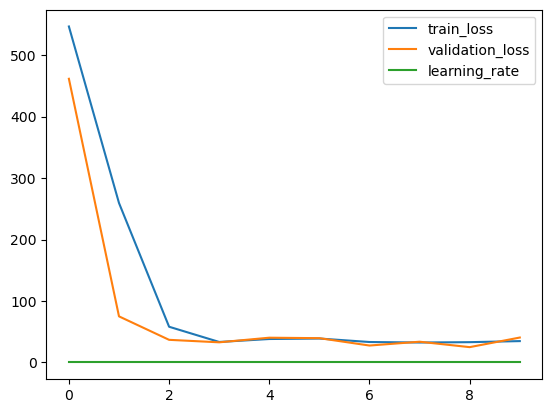

In [13]:
#example using cosmosis/qchem ANI1x dataset with filter and custom model
model_params = {'in_channels': 63*63, 
                'hidden': 2000, 
                'out_channels': 1, 
                'model_name': 'funnel'
               }

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['wb97x_dz.energy']}},
                              'pad_feats': ['coulomb'],
                              'pad': 63, #length of the longest molecule in the dataset
                              'flatten': True,
                              'criterion': ['wb97x_dz.energy'],
                              'conformation': 'max',
                              'in_file': './data/ani1x/ani1x-release.h5'}}

metrics_params = {'report_interval': 20}

crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}
sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 5}
opt_params = {'lr': 0.01}

l = Learn([ANI1x], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          batch_size=64, epochs=10)

In [14]:
!conda list

# packages in environment at /home/operat0r/miniconda3/envs/qchem:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                        main  
_openmp_mutex             5.1                       1_gnu  
aiofiles                  22.1.0             pyhd8ed1ab_0    conda-forge
aiosqlite                 0.19.0             pyhd8ed1ab_0    conda-forge
anyio                     3.7.0              pyhd8ed1ab_1    conda-forge
argon2-cffi               21.3.0             pyhd8ed1ab_0    conda-forge
argon2-cffi-bindings      21.2.0          py310h5764c6d_2    conda-forge
asttokens                 2.2.1              pyhd8ed1ab_0    conda-forge
attrs                     23.1.0             pyh71513ae_1    conda-forge
babel                     2.12.1             pyhd8ed1ab_1    conda-forge
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
backports                 1.0                pyhd8ed1ab_3    conda-forge
backports.func